In [11]:
import pandas as pd
import torch
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import numpy as np
import karman
from karman.nn import *
import os
from torch.utils.data import Subset
from torch import nn
import argparse
from pyfiglet import Figlet
from termcolor import colored
from dataclasses import dataclass
from matplotlib import pyplot as plt
import imageio
from PIL import Image
import io
from IPython.display import Image
from astropy.time import Time
import astropy
from karman import utils
import warnings
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

warnings.filterwarnings("ignore")

In [3]:
global_features =  [
    'space_environment_technologies__f107_average__',
    'space_environment_technologies__f107_obs__',
    'celestrack__ap_average__',
    'celestrack__ap_h_0__',
    'celestrack__ap_h_1__',
    'celestrack__ap_h_2__',
    'celestrack__ap_h_3__',
    'celestrack__ap_h_4__',
    'celestrack__ap_h_5__',
    'celestrack__ap_h_6__',
    'space_environment_technologies__s107_obs__',
    'space_environment_technologies__s107_average__',
    'space_environment_technologies__m107_obs__',
    'space_environment_technologies__m107_average__',
    'space_environment_technologies__y107_obs__',
    'space_environment_technologies__y107_average__',
    'JB08__d_st_dt__[K]',
]

def create_datapoint(date, longitude, latitude, altitude):
    sample = {}
    date = pd.to_datetime(date)
    second_in_day = 3600*date.hour + 60*date.minute + date.second
    day_of_year = date.day_of_year
    t=Time(str(date),location=(f'{longitude}d', f'{latitude}d'))
    sunpos=astropy.coordinates.get_sun(t)
    sun_ra = sunpos.ra.rad
    sun_dec = sunpos.dec.rad
    side_real = t.sidereal_time('mean').rad
    lst = (second_in_day/3600.0 + longitude/15.)

    sample['all__seconds_in_day__[s]_sin'] = np.sin(2*np.pi*second_in_day/(24.0*60*60))
    sample['all__seconds_in_day__[s]_cos'] = np.cos(2*np.pi*second_in_day/(24.0*60*60))

    sample['all__day_of_year__[d]_sin'] = np.sin(2*np.pi*day_of_year/366.0)
    sample['all__day_of_year__[d]_cos'] = np.cos(2*np.pi*day_of_year/366.0)

    sample['all__sun_right_ascension__[rad]_sin'] = np.sin(sun_ra)
    sample['all__sun_right_ascension__[rad]_cos'] = np.cos(sun_ra)

    sample['all__sun_declination__[rad]_sin'] = np.sin(sun_dec)
    sample['all__sun_declination__[rad]_cos'] = np.cos(sun_dec)

    sample['all__sidereal_time__[rad]_sin'] = np.sin(side_real)
    sample['all__sidereal_time__[rad]_cos'] = np.cos(side_real)

    sample['tudelft_thermo__local_solar_time__[h]_sin'] = np.sin(2*np.pi*((lst + 12.0)/48))
    sample['tudelft_thermo__local_solar_time__[h]_cos'] = np.cos(2*np.pi*((lst + 12.0)/48))

    sample['tudelft_thermo__latitude__[deg]'] = float(latitude)

    sample['tudelft_thermo__longitude__[deg]_sin'] = np.sin(2*np.pi*((longitude + 180)/360.0))
    sample['tudelft_thermo__longitude__[deg]_cos'] = np.cos(2*np.pi*((longitude + 180)/360.0))

    sample['all__year__[y]'] = float(date.year)
    sample['tudelft_thermo__altitude__[m]'] = altitude
    return sample

In [4]:
# This cell is to demonstrate that our sin and cos efforts dont quite solve the discontinuity issue
# at the edge of the map (see local solar time values). These datapoints are essentially the same point
# but the local solar time values is completely different. This causes hard barriers because of the sudden jump in one
# particular value. Unsure what to do about that to be honest...This for me is helping to really
# seal in the case for smooth cartesian coordinates, as well as the cartesian subsolar point. Perhaps
# could be a follow up paper. Ideally, the model will learn to deal with these discrepancies, in reality it appears our model
# does not learn smooth transitions...
just_before = create_datapoint('2022-02-02 00:00:00', -180, 0, 250_000)
just_after = create_datapoint('2022-02-02 00:00:00', 180, 0, 250_000)

for key, value in just_before.items():
    if just_before[key] == 0:
        print(key, just_before[key], just_after[key], 1.0)
    else:
        print(key, just_before[key], just_after[key], float(just_after[key]/just_before[key]))

all__seconds_in_day__[s]_sin 0.0 0.0 1.0
all__seconds_in_day__[s]_cos 1.0 1.0 1.0
all__day_of_year__[d]_sin 0.5366961939916004 0.5366961939916004 1.0
all__day_of_year__[d]_cos 0.8437755598231856 0.8437755598231856 1.0
all__sun_right_ascension__[rad]_sin -0.703854525031771 -0.703854525031771 1.0
all__sun_right_ascension__[rad]_cos 0.7103441472922122 0.7103441472922122 1.0
all__sun_declination__[rad]_sin -0.2918410835773317 -0.2918410835773317 1.0
all__sun_declination__[rad]_cos 0.9564668221827712 0.9564668221827712 1.0
all__sidereal_time__[rad]_sin -0.7411526421202649 -0.7411526421202649 1.0
all__sidereal_time__[rad]_cos 0.6713365482961213 0.6713365482961213 1.0
tudelft_thermo__local_solar_time__[h]_sin 0.0 1.2246467991473532e-16 1.0
tudelft_thermo__local_solar_time__[h]_cos 1.0 -1.0 -1.0
tudelft_thermo__latitude__[deg] 0.0 0.0 1.0
tudelft_thermo__longitude__[deg]_sin 0.0 -2.4492935982947064e-16 1.0
tudelft_thermo__longitude__[deg]_cos 1.0 1.0 1.0
all__year__[y] 2022.0 2022.0 1.0
tudelf

In [ ]:
# This cell is to demonstrate that the values are very different for what is essentiually the
# same point in space--- right at the south poles. Again, ideally the model learns to smooth
# over these discontinuities...but it still has them in the images.
just_before = create_datapoint('2022-02-02 00:00:00', -60, -90, 250_000)
just_after = create_datapoint('2022-02-02 00:00:00', 120, -90, 250_000)

for key, value in just_before.items():
    if just_before[key] == 0:
        print(key, just_before[key], just_after[key], 1.0)
    else:
        print(key, just_before[key], just_after[key], float(just_after[key]/just_before[key]))

In [5]:
# This code loads the model. Takes about 3 minutes (sue me)
model_path = '/home/jupyter/karman-project/jb08_inputs/best_model_SimpleNN_1673286175.9505901_fold_2_seed_0' # Just using the first seed (there are actually 5)
model_opt = torch.load(model_path)['opt']
model, dataset = utils.load_model(model_path,
                                  data_directory='/home/jupyter/karman-project/data_directory')

Loading Data
Namespace(batch_size=512, cyclical_features=True, data_directory='/home/jupyter/karman-project/data_directory', dropout=0.0, epochs=10, epochs_per_validation=1, features_to_exclude_fism2_daily_stan_bands='all__dates_datetime__,fism2_daily_stan_bands__E105_0_121_0__[photons/cm**2/s]', features_to_exclude_fism2_flare_stan_bands='all__dates_datetime__', features_to_exclude_omni='all__dates_datetime__,omniweb__id_for_imf_spacecraft__,omniweb__id_for_sw_plasma_spacecraft__,omniweb__#_of_points_in_imf_averages__,omniweb__#_of_points_in_plasma_averages__,omniweb__percent_of_interpolation__,omniweb__timeshift__[s],omniweb__rms_timeshift__[s],omniweb__rms_min_variance__[s**2],omniweb__time_btwn_observations__[s],omniweb__rms_sd_b_scalar__[nT],omniweb__rms_sd_b_field_vector__[nT],omniweb__flow_pressure__[nPa],omniweb__electric_field__[mV/m],omniweb__plasma_beta__,omniweb__alfven_mach_number__,omniweb__magnetosonic_mach_number__,omniweb__s/cx_gse__[Re],omniweb__s/cy_gse__[Re],omniweb

17 years to iterate through.: 100%|██████████| 17/17 [01:48<00:00,  6.39s/it]


Train size: 27719788
Validation size: 3011830
Test size: 2575188


In [6]:
# This cell creates a dataset with the space x data loaded
# have to do it like this to keep the correct scaler from the model run.
space_x_end = pd.to_datetime('2022-03-05')
space_x_start = pd.to_datetime('2022-01-03')
space_x_dataset = karman.ThermosphericDensityDataset(
    directory=model_opt.data_directory,
    create_cyclical_features=model_opt.cyclical_features,
    max_date=space_x_end,
    min_date=space_x_start,
    features_to_exclude_thermo=model_opt.features_to_exclude_thermo.split(','),
    thermo_scaler=dataset.data_thermo['scaler'],
)
space_x_dataset.thermospheric_density = space_x_dataset.data_thermo['data']['tudelft_thermo__ground_truth_thermospheric_density__[kg/m**3]'].values
thermospheric_density_log=np.log(space_x_dataset.thermospheric_density*1e12)
space_x_dataset.thermospheric_density_log_min = dataset.thermospheric_density_log_min
space_x_dataset.thermospheric_density_log_max = dataset.thermospheric_density_log_max
space_x_dataset.thermospheric_density = space_x_dataset.minmax_normalize(
    thermospheric_density_log,
    space_x_dataset.thermospheric_density_log_min,
    space_x_dataset.thermospheric_density_log_max)
space_x_dataset.thermospheric_density = torch.tensor(space_x_dataset.thermospheric_density).to(dtype=torch.float32).detach()

Creating thermospheric density dataset
Creating cyclical features
['all__dates_datetime__', 'tudelft_thermo__ground_truth_thermospheric_density__[kg/m**3]', 'tudelft_thermo__satellite__', 'celestrack__ap_h_0__', 'celestrack__ap_h_1__', 'celestrack__ap_h_2__', 'celestrack__ap_h_3__', 'celestrack__ap_h_4__', 'celestrack__ap_h_5__', 'celestrack__ap_h_6__', 'celestrack__ap_average__', 'JB08__thermospheric_density__[kg/m**3]', 'NRLMSISE00__thermospheric_density__[kg/m**3]']
['all__day_of_year__[d]', 'all__seconds_in_day__[s]', 'all__sun_right_ascension__[rad]', 'all__sun_declination__[rad]', 'all__sidereal_time__[rad]', 'tudelft_thermo__longitude__[deg]', 'tudelft_thermo__local_solar_time__[h]']
Used features: Index(['all__year__[y]', 'tudelft_thermo__altitude__[m]',
       'tudelft_thermo__latitude__[deg]',
       'space_environment_technologies__f107_average__',
       'space_environment_technologies__f107_obs__',
       'space_environment_technologies__s107_obs__',
       'space_environm

In [7]:
# This cell is to show the difference between what should be very similar points- to make sure 
# there are not discontinuities. The idea is that longitude -180 and 180 should be the same point
# but due to the discrepancy in local solar time, they are not.
date = pd.to_datetime('2022-06-01 00:00:00')
location_nearest_date = (space_x_dataset.data_thermo['data']['all__dates_datetime__']-date).abs().argsort()[:1]
global_feature_data = space_x_dataset.data_thermo['data'].loc[location_nearest_date, global_features]
altitude = 250_000
longitudes = [-180, 180]
latitude = 60
data_points = []

for longitude in longitudes:
    new_datapoint = create_datapoint(date, longitude, latitude, altitude)
    full_datapoint = {**global_feature_data.iloc[0].to_dict(), **new_datapoint}
    print(full_datapoint)
    data_point = np.zeros((1, len(dataset.thermo_features)))
                
    for i, feature in enumerate(dataset.thermo_features):
        data_point[0, i] = full_datapoint[feature]

    data_points.append(full_datapoint)
    thermo_features = dataset.data_thermo['scaler'].transform(data_point)
    batch = {
        'instantaneous_features': torch.FloatTensor(thermo_features.flatten()).unsqueeze(0)
    }
    print(dataset.unscale_density(model.forward(batch).detach().cpu().numpy()))

for key in data_points[0].keys():
    if key in dataset.thermo_features:
        print(key, data_points[0][key], data_points[1][key])


{'space_environment_technologies__f107_average__': 112.0999984741211, 'space_environment_technologies__f107_obs__': 109.0, 'celestrack__ap_average__': 27.0, 'celestrack__ap_h_0__': 27.0, 'celestrack__ap_h_1__': 18.0, 'celestrack__ap_h_2__': 18.0, 'celestrack__ap_h_3__': 9.0, 'celestrack__ap_h_4__': 7.0, 'celestrack__ap_h_5__': 8.625, 'celestrack__ap_h_6__': 2.75, 'space_environment_technologies__s107_obs__': 88.5999984741211, 'space_environment_technologies__s107_average__': 92.5999984741211, 'space_environment_technologies__m107_obs__': 116.4000015258789, 'space_environment_technologies__m107_average__': 120.5, 'space_environment_technologies__y107_obs__': 116.4000015258789, 'space_environment_technologies__y107_average__': 131.6999969482422, 'JB08__d_st_dt__[K]': 50.0, 'all__seconds_in_day__[s]_sin': 0.0, 'all__seconds_in_day__[s]_cos': 1.0, 'all__day_of_year__[d]_sin': 0.5074150932938458, 'all__day_of_year__[d]_cos': -0.861701759948068, 'all__sun_right_ascension__[rad]_sin': 0.93091

100%|██████████| 35/35 [00:03<00:00, 10.12it/s]


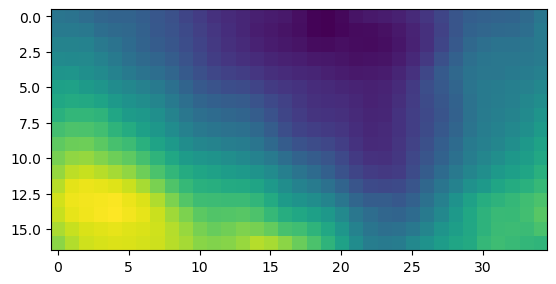

In [8]:
# This cell creates a global map of densities for the loaded model for a certain time
# It creates a list of images with latitude along the y-axis and longitude along the x-axis
date_start = '2022-02-02 00:00:00' #Space x dates
date_end = '2022-02-05 00:00:00'
dates = list(pd.date_range(start=date_start, end=date_end, freq='120T'))
bin_size = 10

altitude = 300_000
longitudes = list(range(-180 + int(bin_size/2),180-int(bin_size/2),bin_size))
latitudes = list(range(-90 + int(bin_size/2),90-int(bin_size/2),bin_size))

images = []

for date in dates:
    location_nearest_date = (space_x_dataset.data_thermo['data']['all__dates_datetime__']-date).abs().argsort()[:1]
    global_feature_data = space_x_dataset.data_thermo['data'].loc[location_nearest_date, global_features]
    records = []
    input_data = []
    for longitude in tqdm(longitudes):
        for latitude in latitudes:
            new_datapoint = create_datapoint(date, longitude, latitude, altitude)
            full_datapoint = {**global_feature_data.iloc[0].to_dict(), **new_datapoint}
            data_point = np.zeros((1, len(dataset.thermo_features)))
            
            for i, feature in enumerate(dataset.thermo_features):
                data_point[0, i] = full_datapoint[feature]
 
            thermo_features = dataset.data_thermo['scaler'].transform(data_point)

            input_data.append(torch.FloatTensor(thermo_features.flatten()).unsqueeze(0))

            records.append({
                'date': date,
                'longitude': longitude,
                'latitude': latitude,
                'altitude': altitude
            })

    dataframe = pd.DataFrame.from_records(records)
    dataframe.index = pd.to_datetime(dataframe['date'])

    batch =  {
        'instantaneous_features': torch.cat(input_data)
    }
    with torch.no_grad():
        model_output = model.forward(batch).detach().cpu().numpy()


    dataframe['density'] = dataset.unscale_density(model_output)

    image = np.zeros((len(latitudes), len(longitudes)))

    for lat_i, latitude in enumerate(latitudes):
        data = dataframe[dataframe['latitude'] == latitude]['density'].values
        image[len(latitudes) - lat_i - 1, :] = data.flatten()

    plt.imshow(image)
    images.append(image)

with open('images.pickle', 'wb') as f:
    pickle.dump(images, f)

In [9]:
with open('images.pickle', 'rb') as f:
    images = pickle.load(f)

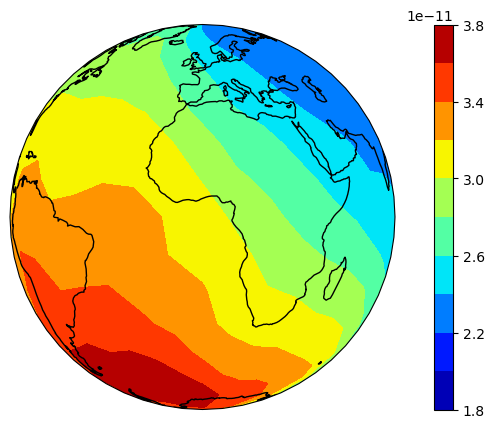

In [12]:
# which date would you like to plot?
required_date = pd.to_datetime('2022-02-03 18:00:00') # edit date here

def plot_image_data(image, projection=ccrs.Orthographic):
    """
    Plot a map of the globe for a particular image
    """
    image = np.flipud(image.copy())
    nlats, nlons = image.shape
    lats = np.linspace(-np.pi / 2, np.pi / 2, nlats)
    lons = np.linspace(-np.pi, np.pi, nlons)
    lons, lats = np.meshgrid(lons, lats)

    lats = np.rad2deg(lats)
    lons = np.rad2deg(lons)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=projection(central_longitude=0, central_latitude=0))

    im = ax.contourf(lons, lats, image, 10,
                transform=ccrs.PlateCarree(),
                cmap='jet')
    ax.coastlines()
    ax.set_global()
    plt.colorbar(im)
    plt.savefig('global_map.png', dpi=1000, bbox_inches='tight')
    plt.show()


def get_image_index(date, date_range):
    for image_index, date in enumerate(list(date_range)):
        if pd.to_datetime(date) == required_date:
            return image_index
    
    raise Exception('Date not found in date list')

image_index = get_image_index(required_date, dates)

plot_image_data(images[image_index])

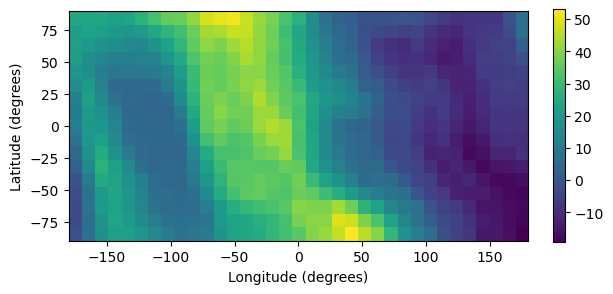

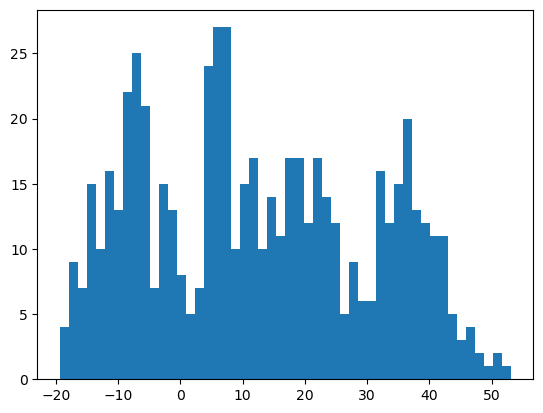

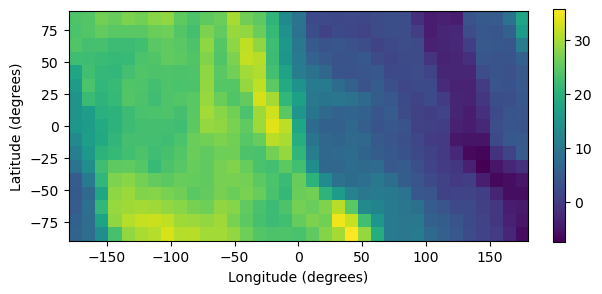

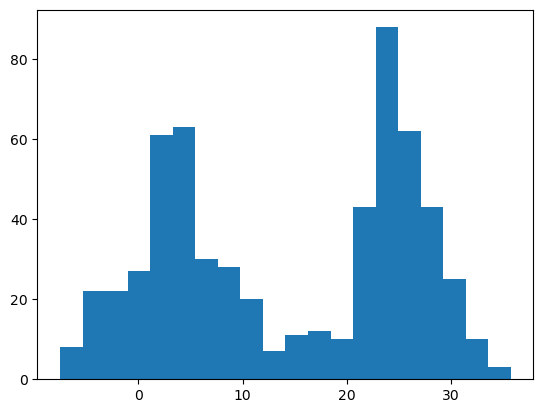

In [13]:
# This cell creates a map showing peak density for each pixel in the global images
# for each of the days, 3rd and 4th of February. It then says what the percentage increase
# in the recorded peak for that grid square was compared with the 2nd of february.
# Also outputs a histogram of the increases too.
second_february = images[0:12]
third_february = images[12:24]
fourth_february = images[24:36]

def max_per_pixel(images):
    stacked_images = np.stack(images)
    max_per_pixel = np.max(stacked_images, axis=0)
    return max_per_pixel

second_feb_max = max_per_pixel(second_february)
third_feb_max = max_per_pixel(third_february)
fourth_feb_max = max_per_pixel(fourth_february)

third_to_second_peak_increase = 100 * np.divide(third_feb_max - second_feb_max, second_feb_max)
fourth_to_second_peak_increase = 100 * np.divide(fourth_feb_max - second_feb_max, second_feb_max)

im = plt.imshow(third_to_second_peak_increase, extent=[-180, 180, -90, 90])
plt.colorbar(im,fraction=0.0235, pad=0.05)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.savefig('3rd_feb_peak_increase.png', dpi=300)
plt.show()

n, bins, patches = plt.hist(third_to_second_peak_increase.flatten(), bins=50)
plt.savefig('3rd_feb_peak_increase_hist.png', dpi=300)
plt.show()

im = plt.imshow(fourth_to_second_peak_increase, extent=[-180, 180, -90, 90])
plt.colorbar(im,fraction=0.0235, pad=0.05)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.savefig('4th_feb_peak_increase.png', dpi=300)
plt.show()

n, bins, patches = plt.hist(fourth_to_second_peak_increase.flatten(), bins=20)
plt.savefig('4th_feb_peak_increase_hist.png', dpi=300)
plt.show()


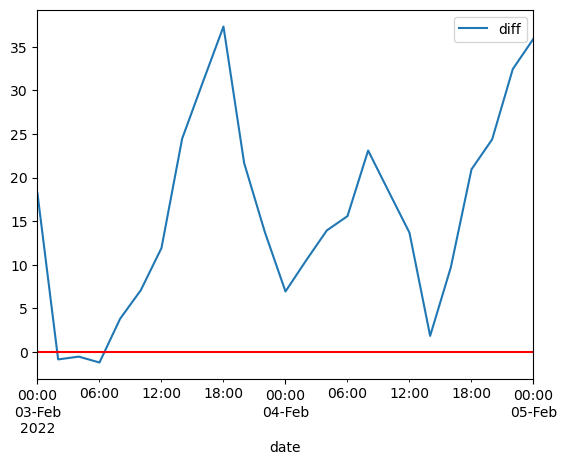

In [14]:
# Plots the density increase at two hour intervals from 3rd february to the end of the 4th compared to
# the mean of global mean densities over the second february. This gives an idea of how
# much denser the globe is.

dates = pd.date_range(start='2022-02-02 00:00:00', end='2022-02-05 00:00:00', freq='120T')
records = []
means = []
second_february_mean = np.stack(second_february).mean()
for i, image in enumerate(images):
    # Calculate the mean per pixel
    mean = image.mean()
    record = {
        'global_mean': mean,
        'date': dates[i],
        'diff': 100 * (mean-second_february_mean)/second_february_mean
    }
    records.append(record)
    
    means.append(mean)
dataframe = pd.DataFrame.from_records(records)
dataframe.index = pd.to_datetime(dataframe['date'])
dataframe.loc['2022-02-03':].plot(y='diff')
plt.axhline(y=0, color='r')

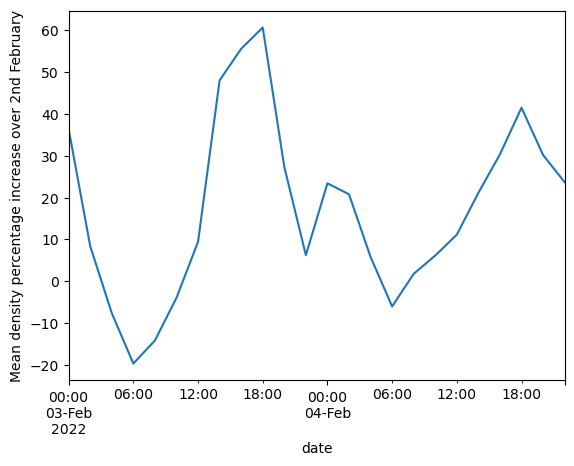

In [15]:
# This cell plots the global mean density for the period 3rd to 4th february
# compared to the same time on the second. The mean of the image every 2 hours is taken
# and compared to the same time on the second. So feb-03 2pm is compares to feb-02 2pm.

def get_percentage_increase(date):
    density = dataframe.loc[date]['global_mean']
    feb_02_density = dataframe.loc[f'{date.year}-02-02 {str(date.hour).zfill(2)}-{str(date.minute).zfill(2)}-{str(date.second).zfill(2)}']['global_mean']
    return 100 * (density - feb_02_density)/feb_02_density

dataframe['mean_density_increase'] = dataframe['date'].apply(get_percentage_increase)
dataframe.loc['2022-02-03':'2022-02-04'].plot(y='mean_density_increase', legend=False)

plt.ylabel('Mean density percentage increase over 2nd February')
plt.savefig('bin_mean_density.png', dpi=300)